In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import arviz

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
run_pgdl_da = np.load("../../run-pgdl-da/2_model_prep/out/data_train_530c0eca-9404-11ec-ab6a-49525eb67875.npz",
                   allow_pickle = True)

x = torch.from_numpy(run_pgdl_da['x_trn_fine']).float()
y = torch.from_numpy(run_pgdl_da['obs']).float()

x.shape, y.shape

(torch.Size([31, 11159, 6]), torch.Size([31, 11159, 1]))

# Define and load models

In [3]:
import torch
import torch.nn as nn
from typing import Dict
import time


# Simple LSTM made from scratch
#   Credit to / code modified from - https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
#   Associated github repo - https://github.com/piEsposito/pytorch-lstm-by-hand
class LSTMDA(nn.Module):
    def __init__(self, input_dim, hidden_dim, recur_dropout = 0, dropout = 0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        # See the file "neuralnet_math_README.md" in the root directory for
        # equations and implementation details
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()
        
        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x, init_states = None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
        
        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * self.recur_dropout(g_t)
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim= 1)
        return hidden_seq, (h_t, c_t)

# Credit to / code modified from https://github.com/neuralhydrology/neuralhydrology     
class CMAL(nn.Module):
    """Countable Mixture of Asymmetric Laplacians.
    An mixture density network with Laplace distributions as components.
    The CMAL-head uses an additional hidden layer to give it more expressiveness (same as the GMM-head).
    CMAL is better suited for many hydrological settings as it handles asymmetries with more ease. However, it is also
    more brittle than GMM and can more often throw exceptions. Details for CMAL can be found in [#]_.
    Parameters
    ----------
    n_in : int
        Number of input neurons.
    n_out : int
        Number of output neurons. Corresponds to 4 times the number of components.
    n_hidden : int
        Size of the hidden layer.
        
    References
    ----------
    .. [#] D.Klotz, F. Kratzert, M. Gauch, A. K. Sampson, G. Klambauer, S. Hochreiter, and G. Nearing: 
        Uncertainty Estimation with Deep Learning for Rainfall-Runoff Modelling. arXiv preprint arXiv:2012.14295, 2020.
    """

    def __init__(self, n_in: int, n_out: int, n_hidden: int = 100):
        super(CMAL, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_out)

        self._softplus = torch.nn.Softplus(2)
        self._eps = 1e-5

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Perform a CMAL head forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Output of the previous model part. It provides the basic latent variables to compute the CMAL components.
        Returns
        -------
        Dict[str, torch.Tensor]
            Dictionary, containing the mixture component parameters and weights; where the key 'mu'stores the means,
            the key 'b' the scale parameters, the key 'tau' the skewness parameters, and the key 'pi' the weights).
        """
        h = torch.relu(self.fc1(x))
        h = self.fc2(h)
        
        m_latent, b_latent, t_latent, p_latent = h.chunk(4, dim=-1)

        # enforce properties on component parameters and weights:
        m = m_latent  # no restrictions (depending on setting m>0 might be useful)
        b = self._softplus(b_latent) + self._eps  # scale > 0 (softplus was working good in tests)
        t = (1 - self._eps) * torch.sigmoid(t_latent) + self._eps  # 0 > tau > 1
        p = (1 - self._eps) * torch.softmax(p_latent, dim=-1) + self._eps  # sum(pi) = 1 & pi > 0

        return {'mu': m, 'b': b, 'tau': t, 'pi': p}

class LSTMDAwithHead(nn.Module):
    def __init__(self, input_dim, lstm_hidden_dim, recur_dropout,
                 dropout, head, head_hidden_dim, head_n_dist):
        super().__init__()
        self.lstm_layer = LSTMDA(input_dim = input_dim,
                                 hidden_dim = lstm_hidden_dim, 
                                 recur_dropout = recur_dropout, 
                                 dropout = dropout)
        assert(head in ['GMM', 'CMAL', 'UMAL', 'Regression'])
        if head == 'GMM':
            self.head_layer = GMM(n_in = lstm_hidden_dim,
                                  n_hidden = head_hidden_dim,
                                  n_out = 3*head_n_dist)
        if head == 'CMAL':
            self.head_layer = CMAL(n_in = lstm_hidden_dim,
                                   n_hidden = head_hidden_dim,
                                   n_out = 4*head_n_dist)
        if head == 'UMAL':
            self.head_layer = UMAL(n_in = lstm_hidden_dim,
                                   n_hidden = head_hidden_dim,
                                   n_out = 2*head_n_dist)
        if head == 'Regression':
            self.head_layer = Regression(n_in = lstm_hidden_dim,
                                         n_out = 1)
        
    def forward(self, x, init_states = None):
        lstm_out, (h, c) = self.lstm_layer(x, init_states)
        out = self.head_layer(lstm_out)
        return out # dont return states; this allows captum usage

In [4]:
model = LSTMDAwithHead(6, 6, 0, 0, 'CMAL', 3, 1)

In [5]:
weights_path = '../../run-pgdl-da/3_model_train/out/a05997a0-94cd-11ec-9999-3fdced87db1b_wgts/weights.pth'
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

# Find some interesting points to look at

In [6]:
all_out = model(x)

In [7]:
np.argmin(all_out['mu'][0].detach()), np.argmax(all_out['mu'][0].detach())

(tensor(3397), tensor(644))

In [8]:
np.argmin(all_out['b'][0].detach()), np.argmax(all_out['b'][0].detach())

(tensor(3397), tensor(8974))

In [9]:
np.argmin(all_out['tau'][0].detach()), np.argmax(all_out['tau'][0].detach())

(tensor(3399), tensor(644))

# Defining expected gradients as a function and performing the same integrated gradients experiments

In [10]:
def expected_gradients(x, x_set, parameter, model, n_samples, temporal_focus=None, spatial_focus=None):
    
    in_seq_len = x.shape[1]
    total_seq_len = x_set.shape[1]
    
    for k in range(n_samples):
        # SAMPLE A RANDOM BASELINE INPUT
        random_start_day = int(np.floor(np.random.uniform(high = (total_seq_len - in_seq_len))))
        baseline_x = x_set[:, random_start_day:(random_start_day+in_seq_len)]

        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        curr_x = baseline_x + scale*x_diff
        if curr_x.requires_grad == False:
            curr_x.requires_grad = True
        model.zero_grad()
        y = model(curr_x)[parameter]

        # GET GRADIENT
        if temporal_focus == None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        elif temporal_focus == None and spatial_focus != None:
            gradients = torch.autograd.grad(y[spatial_focus, :, :], curr_x, torch.ones_like(y[spatial_focus, :, :]))
        elif temporal_focus != None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
        else:
            gradients = torch.autograd.grad(y[spatial_focus, temporal_focus, :], curr_x, torch.ones_like(y[spatial_focus, temporal_focus, :]))

        if k == 0:
            expected_gradients = x_diff*gradients[0] * 1/n_samples
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/n_samples)

    return(expected_gradients)

# attributions for when `mu` and `b` minned

In [11]:
focal_i = 3397

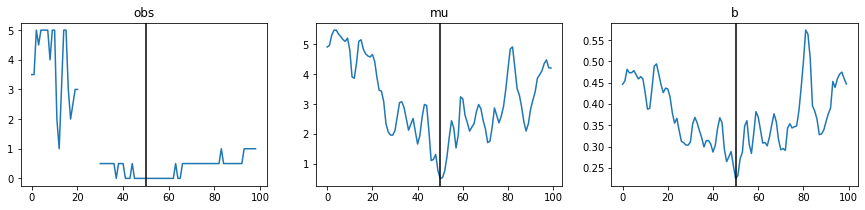

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (15, 3))

ax[0].plot(y[0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[0].axvline(50, color = 'black')
ax[0].set_title('obs')

ax[1].plot(all_out['mu'][0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[1].axvline(50, color = 'black')
ax[1].set_title('mu')

ax[2].plot(all_out['b'][0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[2].axvline(50, color = 'black')
ax[2].set_title('b');

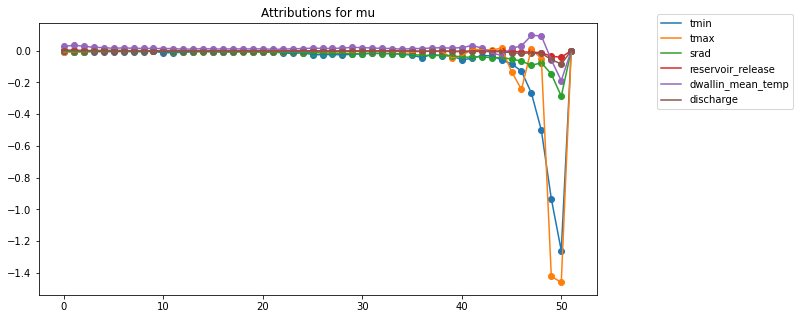

In [13]:
EG_vals = expected_gradients(x[:, (focal_i-50):(focal_i+50)], x, 'mu', model,
                             200, temporal_focus=50, spatial_focus=None)

plt.figure(figsize = (10, 5))
for i in range(6):
    plt.plot(EG_vals[0, :52, i], label = run_pgdl_da["x_vars_trn"][i])
    plt.scatter(range(52), EG_vals[0, :52, i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Attributions for mu');

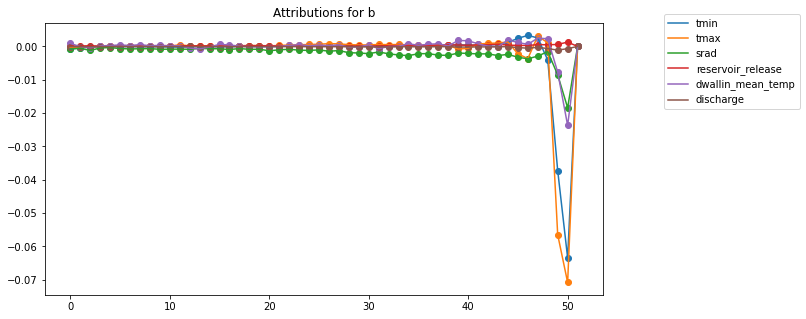

In [14]:
EG_vals = expected_gradients(x[:, (focal_i-50):(focal_i+50)], x, 'b', model,
                             200, temporal_focus=50, spatial_focus=None)

plt.figure(figsize = (10, 5))
for i in range(6):
    plt.plot(EG_vals[0, :52, i], label = run_pgdl_da["x_vars_trn"][i])
    plt.scatter(range(52), EG_vals[0, :52, i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Attributions for b');

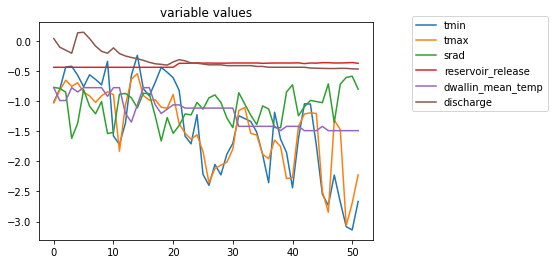

In [15]:
for i in range(6):
    plt.plot(x[0, (focal_i-50):(focal_i+2), i], label = run_pgdl_da['x_vars_trn'][i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('variable values');

# attributions for when `tau` minned

In [16]:
focal_i = 3399

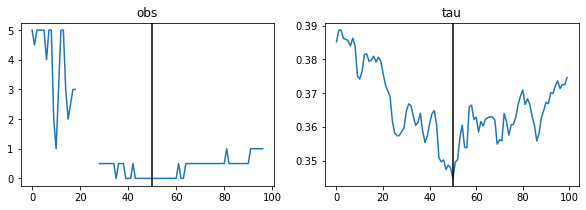

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(y[0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[0].axvline(50, color = 'black')
ax[0].set_title('obs')

ax[1].plot(all_out['tau'][0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[1].axvline(50, color = 'black')
ax[1].set_title('tau');

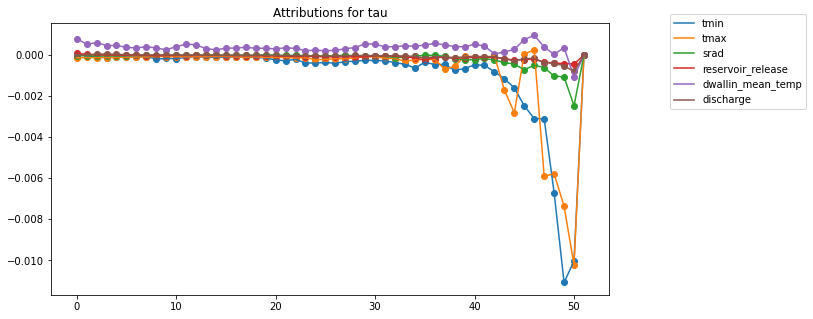

In [18]:
EG_vals = expected_gradients(x[:, (focal_i-50):(focal_i+50)], x, 'tau', model,
                             200, temporal_focus=50, spatial_focus=None)

plt.figure(figsize = (10, 5))
for i in range(6):
    plt.plot(EG_vals[0, :52, i], label = run_pgdl_da["x_vars_trn"][i])
    plt.scatter(range(52), EG_vals[0, :52, i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Attributions for tau');

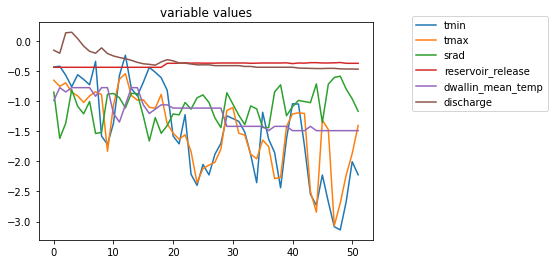

In [19]:
for i in range(6):
    plt.plot(x[0, (focal_i-50):(focal_i+2), i], label = run_pgdl_da['x_vars_trn'][i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('variable values');

# attributions for when `mu` and `tau` maxed

In [20]:
focal_i = 644

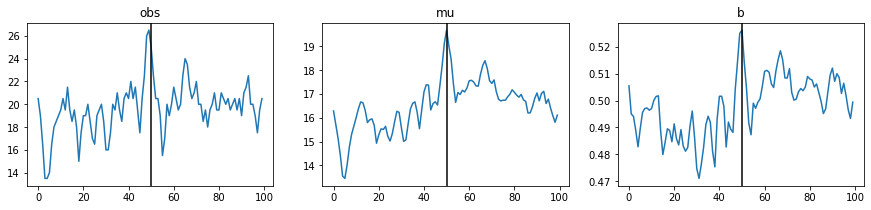

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15, 3))

ax[0].plot(y[0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[0].axvline(50, color = 'black')
ax[0].set_title('obs')

ax[1].plot(all_out['mu'][0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[1].axvline(50, color = 'black')
ax[1].set_title('mu')

ax[2].plot(all_out['tau'][0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[2].axvline(50, color = 'black')
ax[2].set_title('b');

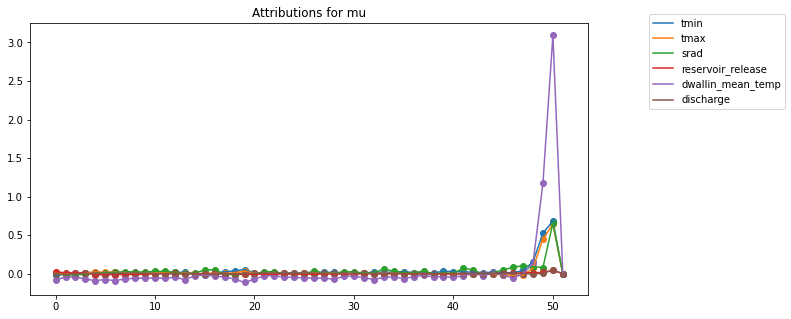

In [22]:
EG_vals = expected_gradients(x[:, (focal_i-50):(focal_i+50)], x, 'mu', model,
                             200, temporal_focus=50, spatial_focus=None)

plt.figure(figsize = (10, 5))
for i in range(6):
    plt.plot(EG_vals[0, :52, i], label = run_pgdl_da["x_vars_trn"][i])
    plt.scatter(range(52), EG_vals[0, :52, i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Attributions for mu');

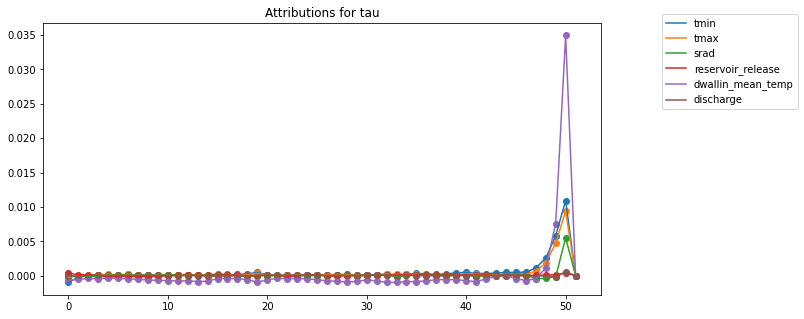

In [23]:
EG_vals = expected_gradients(x[:, (focal_i-50):(focal_i+50)], x, 'tau', model,
                             200, temporal_focus=50, spatial_focus=None)

plt.figure(figsize = (10, 5))
for i in range(6):
    plt.plot(EG_vals[0, :52, i], label = run_pgdl_da["x_vars_trn"][i])
    plt.scatter(range(52), EG_vals[0, :52, i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Attributions for tau');

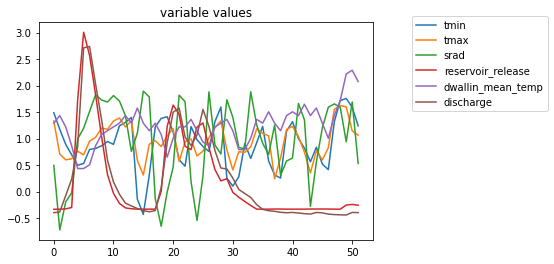

In [24]:
for i in range(6):
    plt.plot(x[0, (focal_i-50):(focal_i+2), i], label = run_pgdl_da['x_vars_trn'][i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('variable values');

# attributions for when `b` maxed

In [25]:
focal_i = 8974

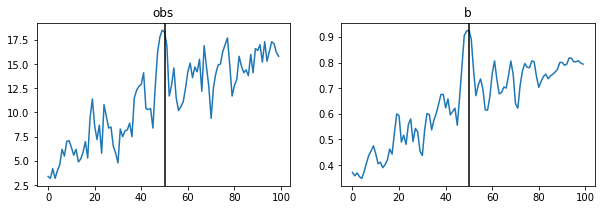

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(y[0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[0].axvline(50, color = 'black')
ax[0].set_title('obs')

ax[1].plot(all_out['b'][0, (focal_i-50):(focal_i+50)].detach().numpy())
ax[1].axvline(50, color = 'black')
ax[1].set_title('b');

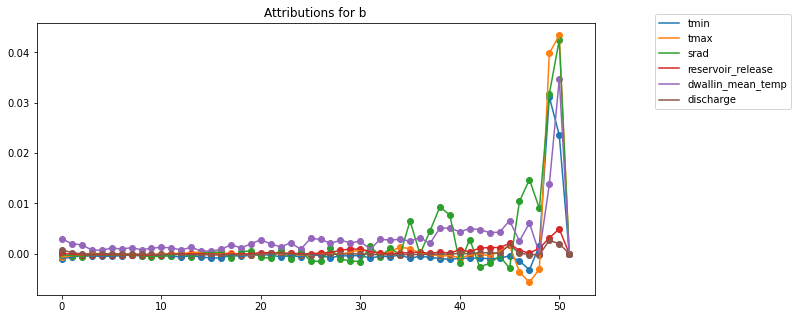

In [27]:
EG_vals = expected_gradients(x[:, (focal_i-50):(focal_i+50)], x, 'b', model,
                             200, temporal_focus=50, spatial_focus=None)

plt.figure(figsize = (10, 5))
for i in range(6):
    plt.plot(EG_vals[0, :52, i], label = run_pgdl_da["x_vars_trn"][i])
    plt.scatter(range(52), EG_vals[0, :52, i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Attributions for b');

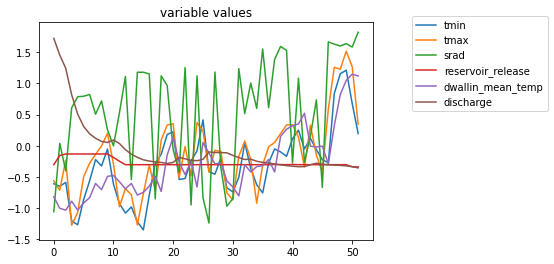

In [28]:
for i in range(6):
    plt.plot(x[0, (focal_i-50):(focal_i+2), i], label = run_pgdl_da['x_vars_trn'][i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('variable values');

# Importance of discharge

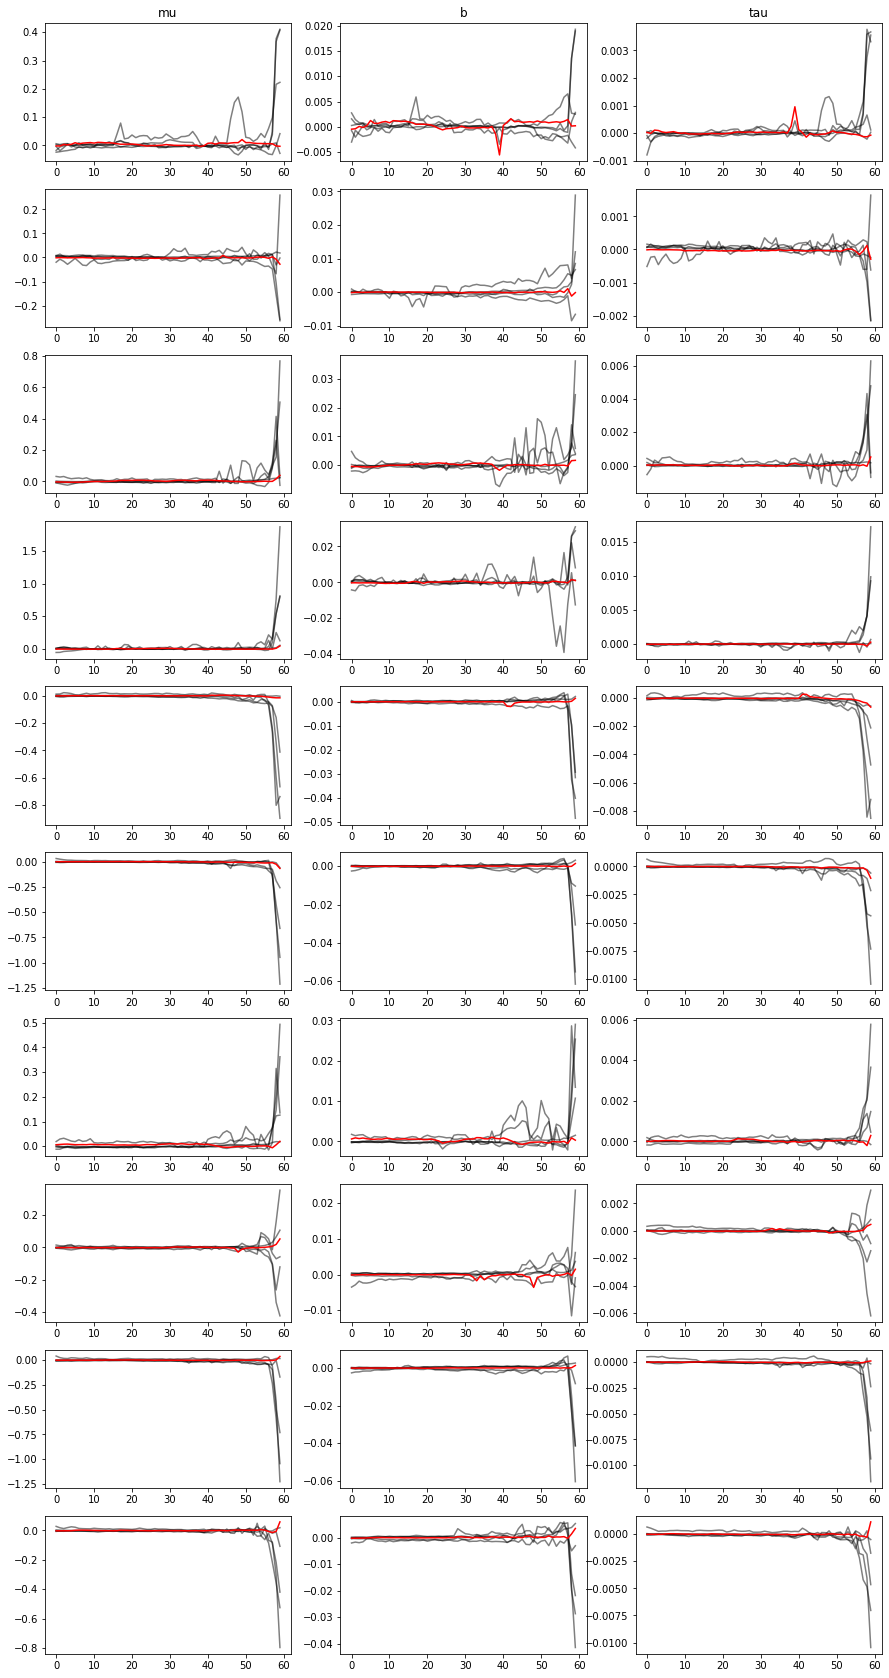

In [29]:
fig, ax = plt.subplots(10, 3, figsize = (15, 30))

for j in range(10):
    # get a random sequence of length 60
    focal_i = int(np.floor(np.random.uniform(high = (x.shape[1] - 60))))
    x_j = x[:, focal_i:(focal_i+60), :]

    count = 0
    for parameter in ['mu', 'b', 'tau']:
        EG_vals = expected_gradients(x_j, x, parameter, model, 200, temporal_focus=-1, spatial_focus=None)
        for i in range(6):
            if i != 5:
                ax[j, count].plot(EG_vals[0, :, i], color = 'black', alpha = 0.5);
            else:
                ax[j, count].plot(EG_vals[0, :, i], color = 'red');
                if j == 0:
                    ax[j, count].set_title(parameter)
        count += 1
        
plt.savefig('discharge_attribution.png')

In [33]:
n = 100

random_i_under_20point5 = np.random.choice(torch.where(y[0, :, 0] < 20.5)[0].numpy(), n)

all_EGs1 = np.zeros([3, n, 6])

count1 = 0
for i in random_i_under_20point5:
    # get a random sequence of length 60
    x_i = x[:, (i-60):i, :]

    count2 = 0
    for parameter in ['mu', 'b', 'tau']:
        EG_vals = expected_gradients(x_i, x, parameter, model, 200, temporal_focus=-1, spatial_focus=None)
        all_EGs1[count2, count1] = np.sum(np.abs(EG_vals[0]).numpy(), axis = 0)
        count2 += 1
    count1 += 1

In [34]:
n = 100

random_i_over_20point5 = np.random.choice(torch.where(y[0, :, 0] > 20.5)[0].numpy(), n)

all_EGs2 = np.zeros([3, n, 6])

count1 = 0
for i in random_i_over_20point5:
    # get a random sequence of length 60
    x_i = x[:, (i-60):i, :]

    count2 = 0
    for parameter in ['mu', 'b', 'tau']:
        EG_vals = expected_gradients(x_i, x, parameter, model, 200, temporal_focus=-1, spatial_focus=None)
        all_EGs2[count2, count1] = np.sum(np.abs(EG_vals[0]).numpy(), axis = 0)
        count2 += 1
    count1 += 1

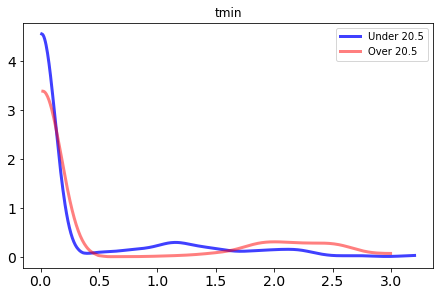

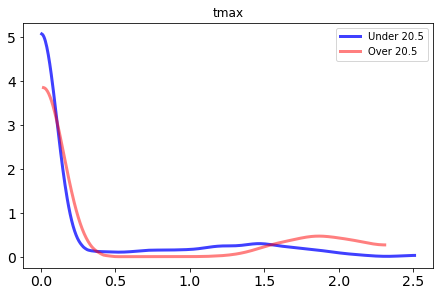

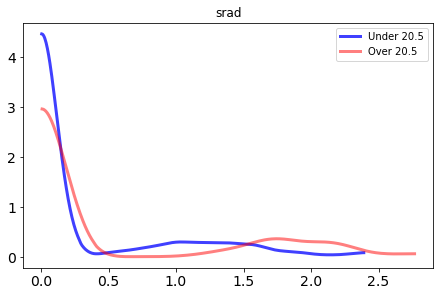

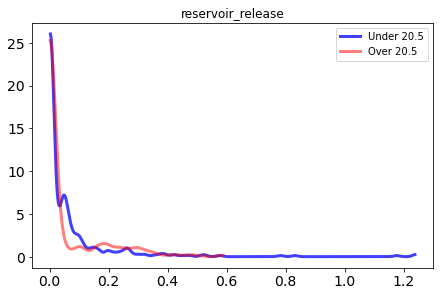

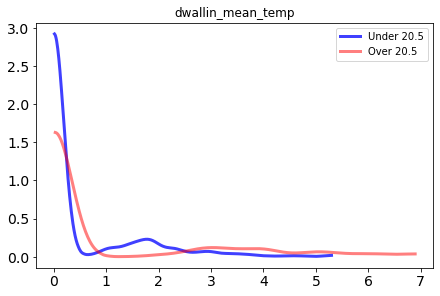

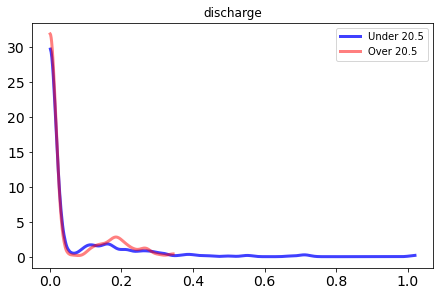

<Figure size 432x288 with 0 Axes>

In [35]:
for i in range(6):
    arviz.plot_kde(all_EGs1[:, :, i].flatten(), label = 'Under 20.5',
                   plot_kwargs = {'color':'blue', 'alpha':0.75, 'linewidth':3})
    arviz.plot_kde(all_EGs2[:, :, i].flatten(), label = 'Over 20.5',
                   plot_kwargs = {'color':'red', 'alpha':0.5, 'linewidth':3})
    plt.legend()
    plt.title(run_pgdl_da['x_vars_trn'][i])
    plt.pause(0.001)
plt.savefig('testing.png')